In [1]:
# Import Python libraries (use Python >= v. 3.9.0)
# ------------------------------------------------

import networkx as nx
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd
import zipfile
import folium
import geojson
import numpy as np
import json
import copy
import heapq
import ipyleaflet as ipl

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from descartes import PolygonPatch
from shapely.geometry import shape
from shapely import geometry
from shapely.geometry.polygon import Polygon, Point
from shapely.ops import unary_union
from distutils import dist


In [2]:
# Load Cambridge LSOA areas
# -------------------------
global_lsoa_pd = pd.read_csv('data/lower_layer_super_output_areas_december_2021.csv', header=0, usecols=[0, 1,2, 3], dtype='string')
cambridge_lsoa_pd = pd.DataFrame(global_lsoa_pd[global_lsoa_pd['LSOA21NM'].str.contains('Cambridge')])
cambridge_lsoa_pd.reset_index(drop=True, inplace=True)
cambridge_lsoa_pd['OBJECTID'] = cambridge_lsoa_pd['OBJECTID'].astype(int)
cambridge_lsoa_pd['LSOA21CD'] = cambridge_lsoa_pd['LSOA21CD'].astype(str)


In [3]:
# Load Cambrideg LSOA population estimates
# ----------------------------------------
global_lsoa_population_estimates_2020_pd = pd.read_csv('data/lsoa_mid_2020_estimates_england.csv', header=0, usecols=[0, 1, 6, 7, 8, 9, 10, 11], dtype='string')
global_lsoa_code_lookup_pd = pd.read_csv('data/LSOA_2011_to_LSOA_2021_Lookup_for_England_and_Wales.csv', header=0, usecols=[0,1,2,3], dtype='string')
global_lsoa_population_estimates_mapped_pd = pd.merge(global_lsoa_population_estimates_2020_pd, global_lsoa_code_lookup_pd, left_on='LSOA Code', right_on='LSOA11CD')
global_lsoa_population_estimates_mapped_pd = global_lsoa_population_estimates_mapped_pd.drop(['LSOA Code', 'LSOA Name', 'LSOA11CD', 'LSOA11NM'], axis=1)
cambridge_lsoa_population_estimates_pd = pd.DataFrame(global_lsoa_population_estimates_mapped_pd[global_lsoa_population_estimates_mapped_pd['LSOA21NM'].str.contains('Cambridge')])
cambridge_lsoa_population_estimates_pd = cambridge_lsoa_population_estimates_pd.drop(['LSOA21NM'], axis=1)
cambridge_lsoa_with_population_pd = pd.merge(cambridge_lsoa_pd, cambridge_lsoa_population_estimates_pd, left_on='LSOA21CD', right_on='LSOA21CD')
cambridge_lsoa_with_population_pd['OBJECTID'] = cambridge_lsoa_with_population_pd['OBJECTID'].astype(str)
cambridge_lsoa_with_population_pd['All Ages'] = cambridge_lsoa_with_population_pd['All Ages'].str.replace(',', '').astype(int)

In [4]:
# Download a geoJSON shapefile for the CB LSOA
# --------------------------------------------

# Split the LSOA object ids to continuous chunks to load from the arcgis end point
# --------------------------------------------------------------------------------
object_ids_chunks = [[]]
prev_objid = cambridge_lsoa_with_population_pd['OBJECTID'].min()
for _, row in cambridge_lsoa_pd.iterrows():
    current_objid = row['OBJECTID']
    if int(current_objid) - int(prev_objid) > 1:
        object_ids_chunks.append([])
    object_ids_chunks[-1].append(current_objid)
    prev_objid = current_objid

# Load the LSOA geofiles from the arcgis and merge into one geogson file for processing
# -------------------------------------------------------------------------------------
lsoa_shapefile = None
for chunk in object_ids_chunks:
    cb_geo_json_link =  f"https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/LSOA_2021_EW_BFC_V2/FeatureServer/0/query?where=OBJECTID>={chunk[0]}%20AND%20OBJECTID<={chunk[-1]}&outFields=*&outSR=4326&f=geojson"
    lsoa_shapefile_r = urllib.request.urlopen(cb_geo_json_link)
    lsoa_shapefile_all = geojson.loads(lsoa_shapefile_r.read())
    if lsoa_shapefile is not None:
        lsoa_shapefile['features'] = lsoa_shapefile_all['features'] + lsoa_shapefile['features']
    else:
        lsoa_shapefile = lsoa_shapefile_all
        
# Filter LSOAs from Cambridge Only - Loading by OBJECTID could bring additional objects not in Cambridge
# ------------------------------------------------------------------------------------------------------
remapped_lsoa = copy.deepcopy(lsoa_shapefile)
remapped_lsoa['features'] = []
for feature in lsoa_shapefile['features']:
    row_json = cambridge_lsoa_with_population_pd.loc[cambridge_lsoa_with_population_pd['LSOA21CD'] == feature['properties']['LSOA21CD']].to_dict(orient="records")
    if len(row_json):
        feature['properties'] =  {**feature['properties'], **row_json[0]}
        remapped_lsoa['features'].append(copy.deepcopy(feature))

In [5]:
# Create a folium map visualising the areas covered by the Cambridge LSOAs
# ------------------------------------------------------------------------

# Defines the highlight and popup style for the choropleth layer
# --------------------------------------------------------------
import branca.colormap as cmp
linear = cmp.LinearColormap(
    ['yellow', 'green', 'blue'],
    vmin=600, vmax=3000,
    caption='Color Scale for Map' #Caption for Color scale or Legend
)

style_function = lambda x: {'fillColor': linear(x['properties']['All Ages']), 
                            'color':'#ffffbf', 
                            'fillOpacity': 0.03, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.5, 
                                'weight': 0.1}

# Create the frame and background folium map 
# ------------------------------------------
frame = folium.Figure(width=500, height=500) #------ Map centred on Cambridge using coordinates
cambridge_map = folium.Map(
    location=[52.20, 0.15], 
    tiles="cartodbpositron",
    zoom_start=13).add_to(frame)

# Add a choropleth with the Cambridge LSOA areas
# ----------------------------------------------
chloro = folium.Choropleth(
    geo_data = remapped_lsoa,
    data = cambridge_lsoa_with_population_pd,
    name = 'Cambridge LSOA',
    columns = ['OBJECTID', 'All Ages'],
    key_on='feature.properties.OBJECTID',
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    highlight = True,
    legend_name="Population"
   )

# Adding a toolip which appears on hover to the postcode choropleth layer
# -----------------------------------------------------------------------
data_on_hover = folium.features.GeoJson(
    data = remapped_lsoa, 
    style_function=style_function, 
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields= ['LSOA21NM', 'All Ages'], 
        aliases=['LSOA Code: ', 'Population: '],
        localize = True))

cambridge_map.add_child(data_on_hover)
cambridge_map.keep_in_front(data_on_hover)
chloro.add_to(cambridge_map)
folium.LayerControl().add_to(cambridge_map)

# Saves the folium map as an html object for use in the webpage
# -------------------------------------------------------------
cambridge_map.save('images/folium/cambridge_lsoa_map.html', "w")

In [6]:
# EPRACCUR GP Practice data ingestion
# -----------------------------------

# Retrvies and saves the most recent EPRACCUR dataset from NHS Digital  webpage
# -----------------------------------------------------------------------------
url = 'https://files.digital.nhs.uk/assets/ods/current/epraccur.zip'
filehandle, _ = urllib.request.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
first_file = zip_file_object.namelist()[0]
file = zip_file_object.open(first_file)
content = file.read()
csv_file = open('data/epraccur_data.csv', 'wb') #-------------- saves the data to the GitHub Repo
csv_file.write(content)
csv_file.close()
header_list = ["Organisation Code", "Name", "National Grouping", "High Level Health Geography", "Address line 1", "Address line 2", "Address line 3", 
"Address line 4", "Address line 5","Postcode","Open Date","Close Date","Status Code","Organisation Sub-Type Code","Commissioner","Join Provider/Purchaser Date",
"Left Provider/Purchaser Date","Contact Telephone Number", "Null 1", "Null 2", "Null 3", "Amended Record Indicator", "Null 4", "Provider/Purchaser",
"Null 5", "Prescribing Setting", "Null 6"] #--------------- Column names are not in the raw data, passed to pandas using the header_list
 
# GP Practice Data Processing
# ---------------------------
gp_practice_df = pd.read_csv('data/epraccur_data.csv', names=header_list)
gp_practice_df = gp_practice_df[(gp_practice_df["Status Code"] == "A") & (gp_practice_df["Prescribing Setting"] == 4) 
&  gp_practice_df["Postcode"].str.startswith('CB')
].reset_index(drop = True)
gp_practice_df['Full Address'] = gp_practice_df[['Address line 2', 'Address line 3', 'Address line 4',]].astype(str).agg(', '.join, axis=1) #------- Joining the address data from various columns to get a full address
gp_practice_df['Full Address'] = gp_practice_df['Full Address'].str.title() + ', ' + gp_practice_df['Postcode'] 
gp_practice_df['Full Address'] = gp_practice_df['Full Address'].str.replace('Nan', '').str.replace(' ,', ' ')
gp_practice_df = gp_practice_df[gp_practice_df["Full Address"].str.contains('Cambridge')].reset_index(drop = True)
gp_practice_df['Name'] = gp_practice_df['Name'].str.title()
gp_practice_df_1 = gp_practice_df[['Organisation Code', 'Name', 'Full Address', 'Postcode', 'Contact Telephone Number']]

In [7]:

# Geolocation of GP practices in Cambridge using GeoPy and the Nomatin API using their postcodes
# ----------------------------------------------------------------------------------------------
gp_practice_df_saved = pd.read_csv('data/cambridge_gp_practices.csv', index_col = 0)
new_list = list(gp_practice_df_1['Organisation Code'])
saved_list = list(gp_practice_df_saved['Organisation Code'])
new_orgs = list(set(new_list) - (set(saved_list))) #------------- Geocoding only occurs if new GP practices in Central Cambridge added to the EPRACCUR dataset
if new_orgs:
    geolocator = Nominatim(user_agent="open_access_nhs") #------------- Setting Nominatim as the API to use during postcode geolocation
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1) #--------- Rate limiting to 1 query per second
    gp_practice_df_1["location"] = gp_practice_df_1["Postcode"].apply(geolocator.geocode)
    gp_practice_df_1["Point"] = gp_practice_df_1["location"].apply(lambda loc: tuple(loc.point) if loc else None)
    gp_practice_df_1[['Latitude', 'Longitude', 'Altitude']] = gp_practice_df_1['Point'].to_list()
    gp_practice_df_2 = gp_practice_df_1[["Organisation Code","Name", "Full Address", "Postcode", "Contact Telephone Number", "Latitude", "Longitude"]]
    gp_practice_df_2.to_csv('data/cambridge_gp_practices.csv') #--------- If new GP practices in the latest EPRACCUR dataset, save a new geocoded Cambridge GP Practice dataset
else:
    gp_practice_df_2 = gp_practice_df_saved.copy()
    print('No new cambridge GP practices')

No new cambridge GP practices


In [8]:
# Map visulation of Cambridge GP practices with Postcode area geoJSON
# -------------------------------------------------------------------
frame = folium.Figure(width=500, height=500) #------ Map centred on Cambridge using coordinates
cambridge_map = folium.Map(
    location=[52.20, 0.15], 
    tiles="cartodbpositron",
    zoom_start=13).add_to(frame)

# Add markers for each of the Cambridge GP practices with contact and location information added as part of a popup
# -----------------------------------------------------------------------------------------------------------------
for code, name, address, number, lat, lon in zip(gp_practice_df_2['Organisation Code'],
gp_practice_df_2['Name'],
gp_practice_df_2['Full Address'],
gp_practice_df_2['Contact Telephone Number'],
gp_practice_df_2['Latitude'],
gp_practice_df_2['Longitude']):
    folium.Marker(
        [lat, lon],
        popup = folium.Popup('<b>' + 'Name: ' + '</b>'  + str(name) + '<br>'
        '<b>' + 'GP Practice Code: ' + '</b>' + str(code) + '<br>'
        '<b>' + 'Address: ' + '</b>' + str(address) + '<br>'
        '<b>' + 'Telephone Number: ' + '</b>' + str(number) + '<br>',
        max_width=len(address)*20),
        icon=folium.Icon(color="darkblue", prefix='fa', icon="fa-medkit"),
        ).add_to(cambridge_map)

# Add a choropleth with the Cambridge LSOA areas
# ----------------------------------------------
chloro = folium.Choropleth(
    geo_data = remapped_lsoa,
    data = cambridge_lsoa_with_population_pd,
    name = 'Cambridge LSOA',
    columns = ['OBJECTID', 'All Ages'],
    key_on='feature.properties.OBJECTID',
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    highlight = True,
    legend_name="Population"
   )

# Adding a toolip which appears on hover to the postcode choropleth layer
# -----------------------------------------------------------------------
data_on_hover = folium.features.GeoJson(
    data = remapped_lsoa, 
    style_function=style_function, 
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields= ['LSOA21NM', 'All Ages'], 
        aliases=['LSOA Code: ', 'Population: '],
        localize = True))

cambridge_map.add_child(data_on_hover)
cambridge_map.keep_in_front(data_on_hover)
chloro.add_to(cambridge_map)
folium.LayerControl().add_to(cambridge_map)

# Saves the folium map as an html object for use in the webpage
# -------------------------------------------------------------
cambridge_map.save("images/folium/cambridge_lsoa_map_no_travel.html", "w")

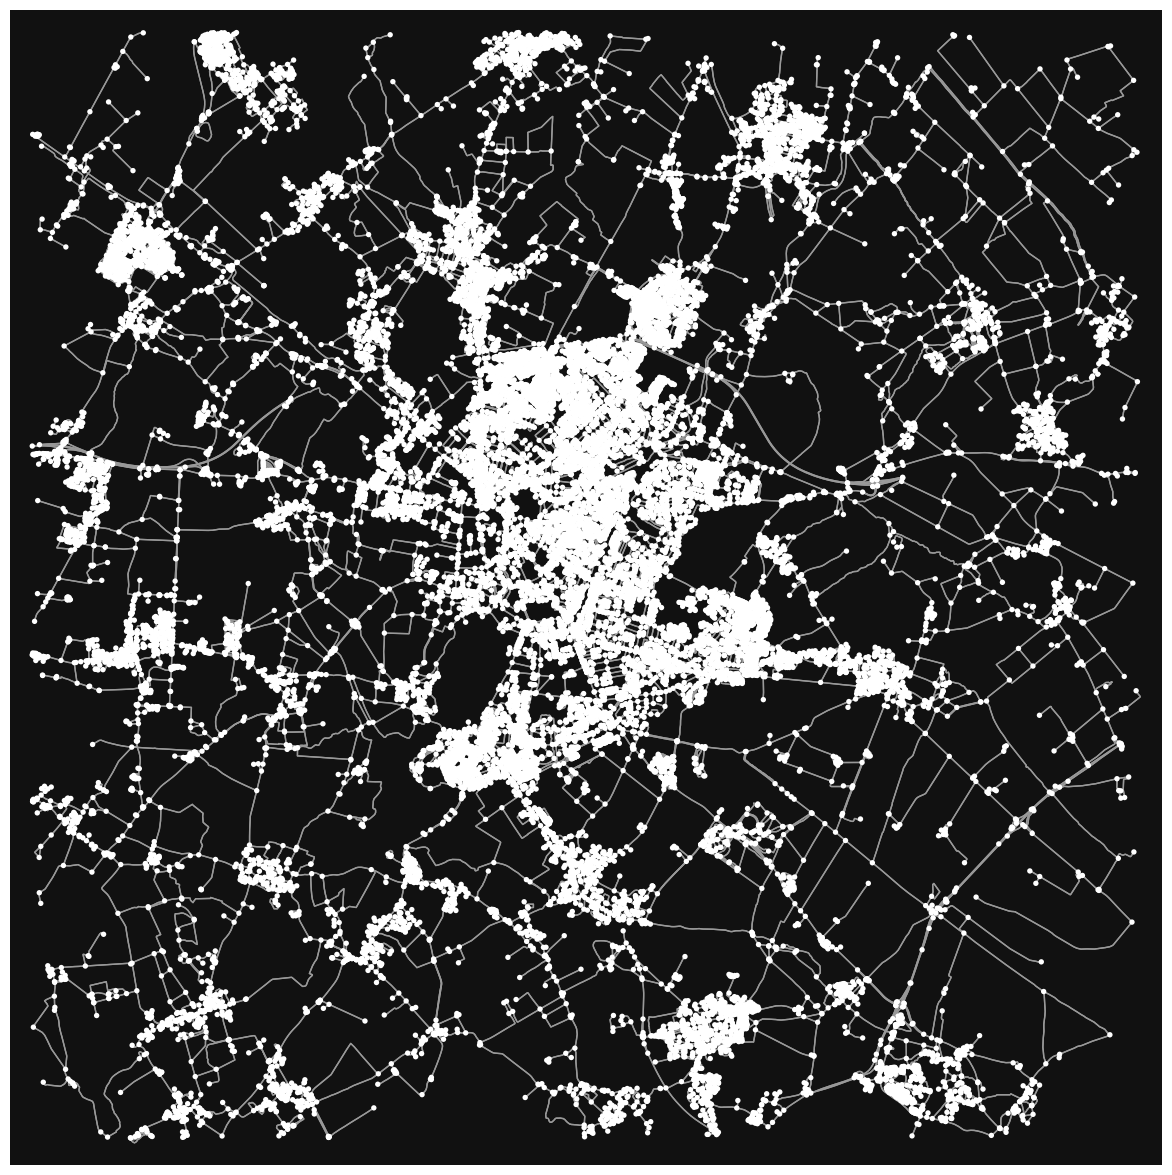

In [9]:
# Time of travel (walking) analysis for GP practices in central Cambridge (10000 meters from centre)
# --------------------------------------------------------------------------------------------------

# Create a OSMnx walkable urban network graph 10000 meters point arbitrarily defined as the centre of Cambridge
# -------------------------------------------------------------------------------------------------------------
place = "Cambridge, England"
mode = "walk"
G = ox.graph_from_address(place, dist = 10000, simplify=True, network_type=mode)
fig, ax = ox.plot_graph(G, figsize = (15,15));

In [10]:
# Map the coordinates of each of the central Cambridge GP practices to the nearest node on OSMnx walkable urban network graph
# ---------------------------------------------------------------------------------------------------------------------------
point_of_interest = ox.distance.nearest_nodes(G, X = gp_practice_df_2['Longitude'], Y=gp_practice_df_2['Latitude']) #---- X = longitude, Y = Latitude

In [11]:
 
# Defining trip times of interest, walking speed, and adding and edge attribute 'time' to each edge in urban network graph
# ------------------------------------------------------------------------------------------------------------------------

# Trip time in Mintues
# --------------------
trip_times = [5,10,20]

# Walking speed in km/hour
# ------------------------
travel_speed = 4.5

# Add an edge attribute for time in minutes required to traverse each edge
# ------------------------------------------------------------------------
meters_per_minute = travel_speed * 1000 / 60 # convert speed in km per hour to meteres per minute as length attribute in edges sorted in metres and travel time specified in minutes
for _, _, _, data in G.edges(data=True, keys=True):  
    data['time'] = data['length'] / meters_per_minute

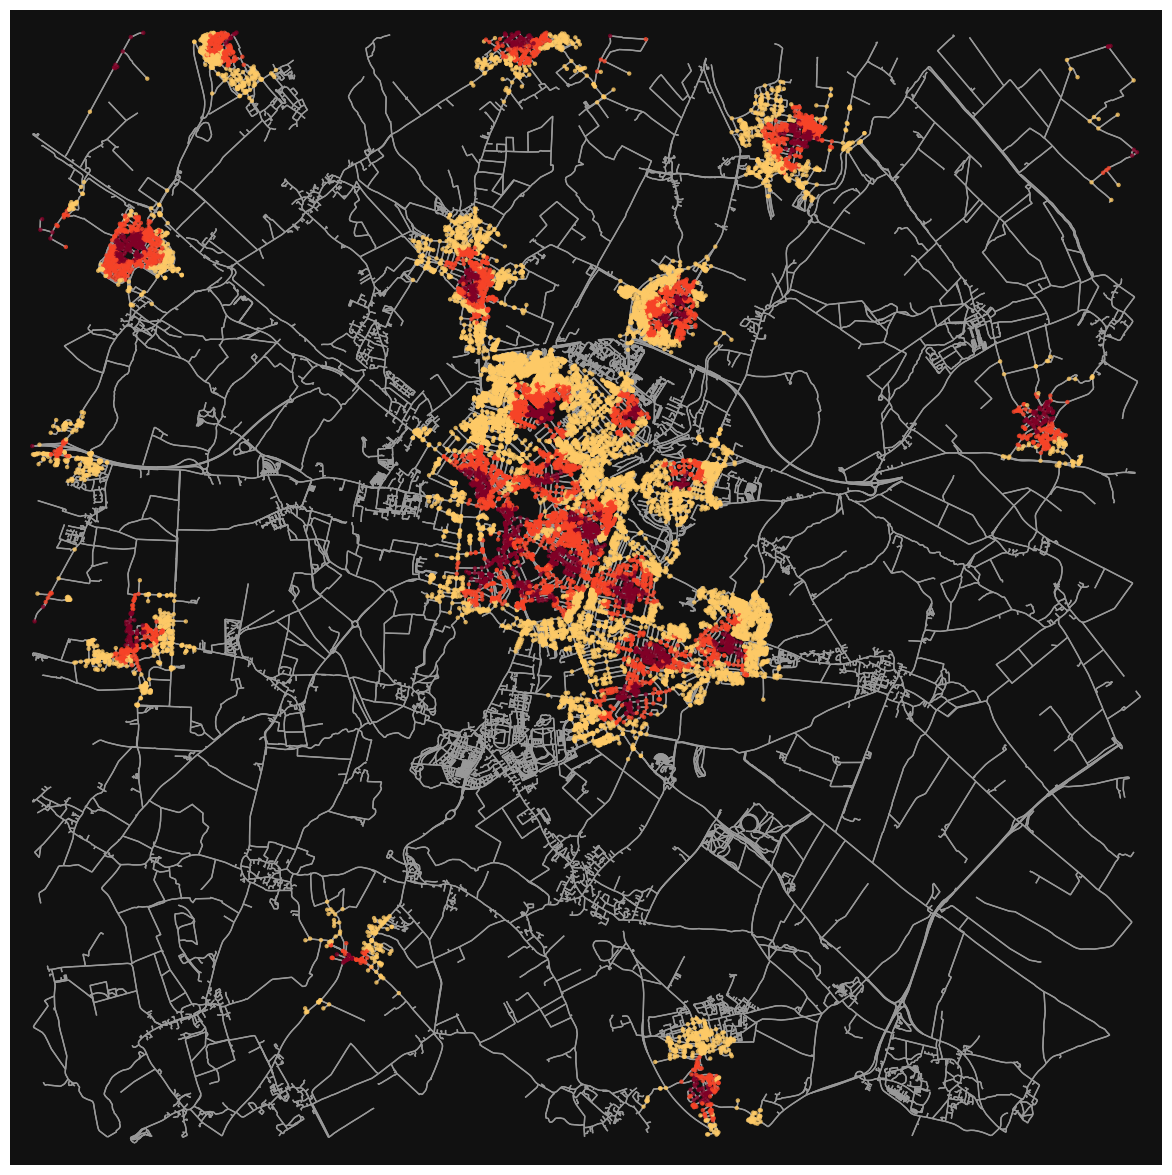

In [12]:
# Retrun one color for each isochrone (each of the trip times) 
# ------------------------------------------------------------
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='YlOrRd', start=0.3, return_hex=True)

# Coolor the nodes according to isochrone then plot the urban network graph
# -------------------------------------------------------------------------
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    for point in point_of_interest:
        subgraph = nx.ego_graph(G, point, radius=trip_time, distance='time') #---- uses the edge attribute 'time' to define the isochrones for each of the trips
        for node in subgraph.nodes():
            node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [10 if node in node_colors else 0 for node in G.nodes()] #------ sets the size of the coloured nodes at '10', while uncoloured nodes (outside trip times) are not visualised
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2, figsize = (15,15))

In [13]:
# For each GP practices generate map of surrounding LSOAs
# -------------------------------------------------------
practices_to_lsoa_map = {}
for index in range(len(point_of_interest)):
    practice_code = gp_practice_df_2.iloc[index]['Organisation Code']
    practice_long_lat = Point((gp_practice_df_2.iloc[index]['Longitude'], gp_practice_df_2.iloc[index]['Latitude']))
    practice_name = gp_practice_df_2.iloc[index]['Name']
    practice_nearest_node = point_of_interest[index]
    subgraph = nx.ego_graph(G, practice_nearest_node, radius=10, distance='time')
    node_points = [Point((data['x'], data['y'])) for _, data in subgraph.nodes(data=True)]
    bounding_poly = Polygon(gpd.GeoSeries(node_points).unary_union.convex_hull)
    practice_info = {'practice_code' : practice_code, 'practice_name' : practice_name, 'lsoa_codes' : [], 'population' : 0, 'max_walking_time': 0, 'polygons' : []}

    # Add mapping between practice and surrounding LSOAs
    # --------------------------------------------------
    for lsoa in remapped_lsoa['features']:
        lsoa_polygon = shape(lsoa['geometry'])
        if lsoa_polygon.contains(practice_long_lat) or bounding_poly.intersects(lsoa_polygon):
            practice_info['lsoa_codes'].append(lsoa['properties']['LSOA21CD'])
            practice_info['population'] = practice_info['population'] + lsoa['properties']['All Ages']
            practice_info['polygons'].append(lsoa_polygon)

            # Calculate the maximum time walking to the practice from surrounding lsoas
            # -------------------------------------------------------------------------
            lsoa_boundaries = Polygon(gpd.GeoSeries(lsoa_polygon).unary_union.convex_hull)
            distances = [(geometry.LineString([practice_long_lat, v]).length, v) for v in lsoa_boundaries.exterior.coords]
            heapq._heapify_max(distances)
            _, xy = distances[0]
            x, y = xy
            max_node = ox.distance.nearest_nodes(G, X = x, Y=y)
            walking_distance = nx.shortest_path_length(G, practice_nearest_node, max_node, weight='time')
            practice_info['max_walking_time'] = max(practice_info['max_walking_time'], walking_distance)

    practices_to_lsoa_map[practice_code] = practice_info

# Create one polygon from the surrounding LSOAs
# ---------------------------------------------
for practice in practices_to_lsoa_map.values():
    practice['surrounding'] = unary_union(practice['polygons'])

In [14]:
# Generate map of Cambridge LSOAs with interactive markers for each practice. Clicking on the marker will shade the surrounding LSOAs
# and will show popup with the total population of the area with maximum walking time to the practice.
# -----------------------------------------------------------------------------------------------------------------------------------
frame = folium.Figure(width=500, height=500) #------ Map centred on Cambridge using coordinates
cambridge_map = folium.Map(
    location=[52.20, 0.15], 
    tiles="cartodbpositron",
    zoom_start=13).add_to(frame)

map_id = f"map_{cambridge_map._id}"
marker_handlers = []
global_layer = folium.FeatureGroup('Practices Only', show=True)
for code, name, address, number, lat, lon in zip(gp_practice_df_2['Organisation Code'],
gp_practice_df_2['Name'],
gp_practice_df_2['Full Address'],
gp_practice_df_2['Contact Telephone Number'],
gp_practice_df_2['Latitude'],
gp_practice_df_2['Longitude']):
    practice = practices_to_lsoa_map[code]

    # Generate selected practice marker
    # ---------------------------------
    selected_marker = folium.map.Marker(
        [lat, lon],
        popup = folium.Popup(
        f"<b> Name: </b>{str(name)}<br>"
        f"<b> GP Practice Code: </b>{str(code)}<br>"
        f"<b> Address: </b>{str(address)}<br>"
        f"<b> Telephone Number: </b>{str(number)}<br>"
        f"<b> Population Estimates: </b>{practice['population']:,}<br>"
        f"<b> Max walking time to the practice: </b>{practice['max_walking_time']:.0f} mins",
        max_width=len(address)*20),
        icon=folium.Icon(color="red", prefix='fa', icon="fa-medkit"))
    
    geojson = gpd.GeoSeries(practice['surrounding']).unary_union
    shape_name = f"{practice['practice_code']}: {practice['practice_name']}"
    fillColor = '#003087'
    area = folium.GeoJson(geojson, name = shape_name, style_function = lambda x, fillColor = fillColor: {
        "fillColor": fillColor,
        "name":  shape_name,
        "weight": 1,
        "fillOpacity": 0.5,
        "color": "#000000",
        })
    
    # Generate the layer of selected practice with surrounding LSOAs
    # --------------------------------------------------------------
    layer = folium.FeatureGroup(shape_name, show=False)
    layer.add_child(selected_marker)
    layer.add_child(area)
    layer.add_to(cambridge_map)
    
    # Generate unselected markers for GP practices
    # --------------------------------------------
    unselected_marker = folium.map.Marker(
        [lat, lon],
        popup = folium.Popup(
        f"<b> Name: </b>{str(name)}<br>"
        f"<b> GP Practice Code: </b>{str(code)}<br>"
        f"<b> Address: </b>{str(address)}<br>"
        f"<b> Telephone Number: </b>{str(number)}<br>"
        f"<b> Population Estimates: </b>{practice['population']:,}<br>"
        f"<b> Max walking time to the practice: </b>{practice['max_walking_time']:.0f} mins",
        max_width=len(address)*20),
        icon=folium.Icon(color="darkblue", prefix='fa', icon="fa-medkit"))
    global_layer.add_child(unselected_marker)
    
    # Generate click handlers for the page to select and unselect the GP practices with surrounding LSOAs
    # ---------------------------------------------------------------------------------------------------
    marker_handlers.append(f"marker_{unselected_marker._id}.on('click', function() {{ feature_group_{layer._id}.addTo({map_id}); }});")
    marker_handlers.append(f"marker_{selected_marker._id}.on('click', function() {{ feature_group_{layer._id}.remove(); }});")
    
global_layer.add_to(cambridge_map)

# Add a choropleth with the Cambridge LSOA areas
# ----------------------------------------------
chloro = folium.Choropleth(
    geo_data = remapped_lsoa,
    data = cambridge_lsoa_with_population_pd,
    name = 'Cambridge LSOA',
    columns = ['OBJECTID', 'All Ages'],
    key_on='feature.properties.OBJECTID',
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    highlight = True,
    legend_name="Population"
   )

# Adding a toolip which appears on hover to the postcode choropleth layer
# -----------------------------------------------------------------------
data_on_hover = folium.features.GeoJson(
    data = remapped_lsoa, 
    style_function=style_function, 
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields= ['LSOA21NM', 'All Ages'], 
        aliases=['LSOA Code: ', 'Population: '],
        localize = True))

cambridge_map.add_child(data_on_hover)
cambridge_map.keep_in_front(data_on_hover)
chloro.add_to(cambridge_map)
folium.LayerControl().add_to(cambridge_map)

# Saves the folium map as an html object for use in the webpage
# -------------------------------------------------------------
cambridge_map.save("images/folium/cambridge_lsoa_map_travel.html")

# Adds the click handlers to the map
# ----------------------------------
import re
import os
with open ("images/folium/cambridge_lsoa_map_travel.html", 'r') as f:
    lines = f.readlines()

for action_handler in marker_handlers:
    lines.insert(-1, action_handler)

with open ("images/folium/cambridge_lsoa_map_travel.html", 'w') as f:
    text = "\n".join(lines)
    f.write(text)
